<a href="https://colab.research.google.com/github/NguyenVanHien8502/image-classification/blob/main/colab_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount google drive

In [62]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [63]:
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
import gzip

# Load Data

In [64]:
#Load image data
filename = '/content/drive/MyDrive/Colab_Notebooks/train-images-idx3-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data_image = np.frombuffer(f.read(), dtype=np.uint8)
    data_image = data_image.reshape(size, nrows, ncols)

In [65]:
#Load label data
filename = '/content/drive/MyDrive/Colab_Notebooks/train-labels-idx1-ubyte.gz'

with gzip.open(filename, 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data_label = np.frombuffer(f.read(), dtype=np.uint8)
    data_label = data_label.reshape((size,))

5


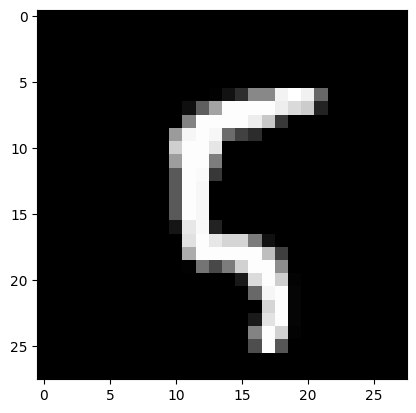

In [66]:
print(data_label[100])
plt.imshow(data_image[100,:,:], cmap='gray')
plt.show()

#TensorFlow

In [67]:
import tensorflow as tf
from tensorflow import keras
from keras.api._v2.keras import layers
print(f"Tensorflow: {tf.__version__}")
# print(f"\nKeras: {tf.keras.__version__}")


Tensorflow: 2.13.0


In [68]:
!pip freeze | grep tensorflow

tensorflow==2.13.0
tensorflow-datasets==4.9.3
tensorflow-estimator==2.13.0
tensorflow-gcs-config==2.13.0
tensorflow-hub==0.15.0
tensorflow-io-gcs-filesystem==0.34.0
tensorflow-metadata==1.14.0
tensorflow-probability==0.20.1


In [69]:
!pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl


#1.Load data

In [70]:
(X_train, y_train), (X_test,y_test)=keras.datasets.fashion_mnist.load_data();

In [71]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [72]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [73]:
X_train.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'))

In [74]:
y_train[0]

9

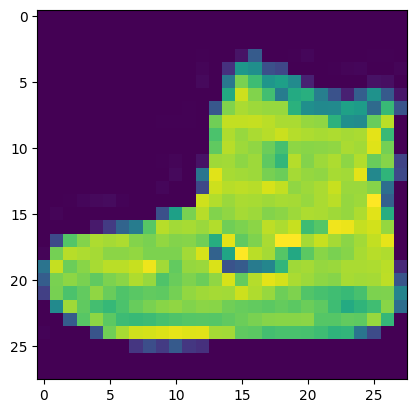

In [75]:
plt.imshow(X_train[0])

In [76]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# class_names = ["Number 0", "Number 1", "Number 2", "Number 3", "Number 4", "Number 5", "Number 6", "Number 7", "Number 8", "Number 9"]
print(class_names[y_train[0]])
class_nums = len(class_names)
print(class_nums)

Ankle boot
10


In [77]:
from typing import Optional
def plot_data(x_data: np.ndarray, y_data:np.ndarray, y_proba: Optional[np.ndarray] = None)->None:
  nrows, ncols=2, 4
  fig, axes = plt.subplots(nrows, ncols, figsize=(8,4))

  len_x = x_data.shape[0]
  for idx in range(nrows*ncols):
    ax = axes[idx // ncols, idx % ncols]
    img_idx = random.randint(0, len_x)
    ax.imshow(x_data[img_idx], cmap='gray')
    ax.set(xticks=[], yticks=[])
    color = 'green'

    true_label_str = f"True: {class_names[y_data[img_idx]]}"

    if y_proba is not None:
      predicted_idx = np.argmax(y_proba[img_idx])
      predicted_label = class_names[predicted_idx]
      color = 'red' if predicted_idx != y_data[img_idx] else color
      predicted_label_str = f"\nPredicted: {predicted_label}"

    img_title = true_label_str if y_proba is None else true_label_str + predicted_label_str
    ax.set_xlabel(img_title, color=color, fontsize=12)

  plt.tight_layout()
  plt.show()

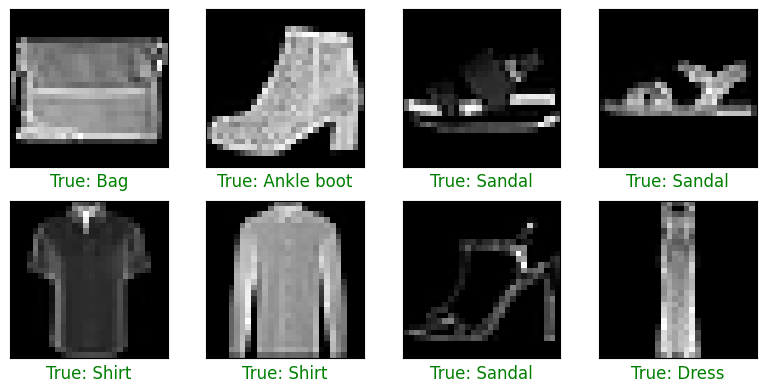

In [78]:
plot_data(X_train, y_train)

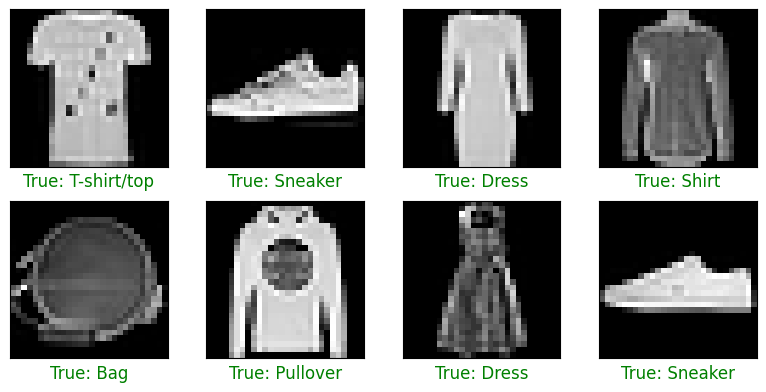

In [79]:
plot_data(X_test, y_test)

#2. Image Pre-processing

In [80]:
#Convert to float32 & scale images to the [0,1] range for training
X_train=X_train.astype(np.float32) / 255
X_test=X_test.astype(np.float32) / 255

In [81]:
X_train.shape, X_train.dtype

((60000, 28, 28), dtype('float32'))

In [82]:
X_test.shape, X_test.dtype

((10000, 28, 28), dtype('float32'))

In [83]:
#Make sure images have shape (60000, 28, 28) => (60000, 28, 28, 1)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [84]:
X_train.shape, X_train.dtype

((60000, 28, 28, 1), dtype('float32'))

In [85]:
X_test.shape, X_test.dtype

((10000, 28, 28, 1), dtype('float32'))

In [86]:
#convert class vector to binary class matrics: 1 => [0 1 0 0 ...]
#1 => sparse_categorical_crossentropy
#[0 1 0 0 ...] => categorical_crossentropy
y_train_label = keras.utils.to_categorical(y_train, class_nums)
y_test_label = keras.utils.to_categorical(y_test, class_nums)

In [87]:
y_train[0], y_train_label[0]

(9, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32))

#3. Network (ANN) Architecture

In [88]:
input_shape = (28, 28, 1)

In [89]:
model = keras.models.Sequential([
    layers.Flatten(input_shape = input_shape), #(28, 28, 1)->vector 1 chiều (28*28)
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(class_nums, activation='softmax'),
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 535818 (2.04 MB)
Trainable params: 535818 (2.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [91]:
epochs = 10
batch_size = 128
history = model.fit(X_train, y_train_label,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.1
          )

Epoch 1/10
422/422 [==============================] - 5s 10ms/step - loss: 0.5623 - accuracy: 0.7951 - val_loss: 0.5200 - val_accuracy: 0.8137
Epoch 2/10
422/422 [==============================] - 7s 15ms/step - loss: 0.3842 - accuracy: 0.8576 - val_loss: 0.3649 - val_accuracy: 0.8682
Epoch 3/10
422/422 [==============================] - 6s 14ms/step - loss: 0.3368 - accuracy: 0.8752 - val_loss: 0.3802 - val_accuracy: 0.8618
Epoch 4/10
422/422 [==============================] - 6s 15ms/step - loss: 0.3093 - accuracy: 0.8851 - val_loss: 0.3396 - val_accuracy: 0.8795
Epoch 5/10
422/422 [==============================] - 5s 11ms/step - loss: 0.2883 - accuracy: 0.8918 - val_loss: 0.3464 - val_accuracy: 0.8760
Epoch 6/10
422/422 [==============================] - 4s 9ms/step - loss: 0.2728 - accuracy: 0.8966 - val_loss: 0.3385 - val_accuracy: 0.8818
Epoch 7/10
422/422 [==============================] - 4s 10ms/step - loss: 0.2611 - accuracy: 0.9015 - val_loss: 0.3328 - val_accuracy: 0.8833


In [92]:
history_dict = history.history

In [93]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [94]:
train_loss, val_loss = history_dict['loss'], history_dict['val_loss']
train_acc, val_acc = history_dict['accuracy'], history_dict['val_accuracy']

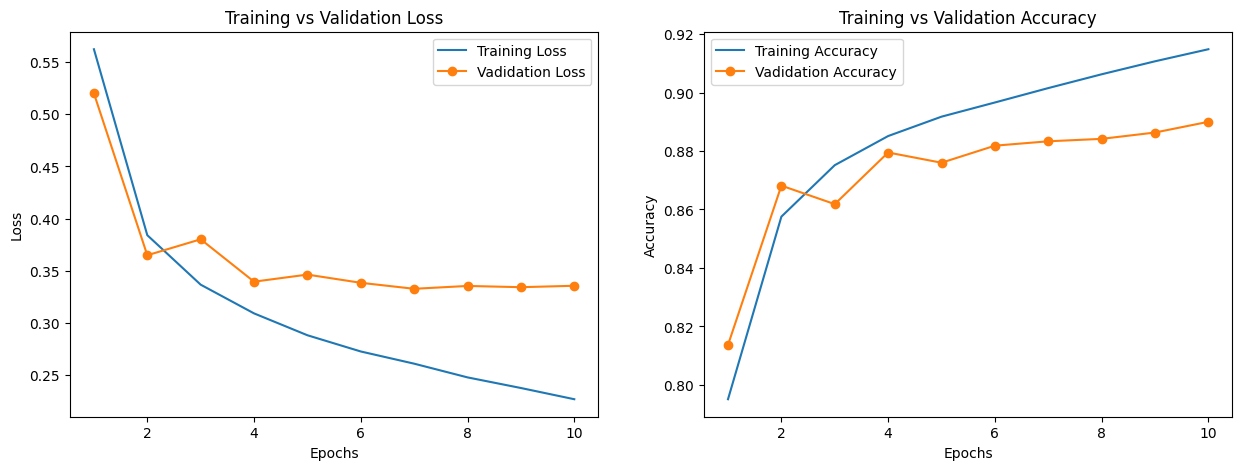

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
epochs_runs = [i+1 for i in range(epochs)]

ax1.plot(epochs_runs, train_loss, label='Training Loss')
ax1.plot(epochs_runs, val_loss, label='Vadidation Loss', marker='o')
ax1.set(title='Training vs Validation Loss', xlabel='Epochs', ylabel='Loss')
ax1.legend()

ax2.plot(epochs_runs, train_acc, label='Training Accuracy')
ax2.plot(epochs_runs, val_acc, label='Vadidation Accuracy', marker='o')
ax2.set(title='Training vs Validation Accuracy', xlabel='Epochs', ylabel='Accuracy')
ax2.legend()

plt.show()

#4. Model Evaluation

In [96]:
score = model.evaluate(X_test, y_test_label)

313/313 [==============================] - 1s 3ms/step - loss: 0.3467 - accuracy: 0.8891


In [97]:
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]:.4f}")

Test Loss: 0.3467
Test Accuracy: 0.8891


In [98]:
X_sample = X_test[:3]
y_proba = model.predict(X_sample)

1/1 [==============================] - 0s 57ms/step


In [99]:
y_proba.round(3)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [100]:
predictions = np.argmax(y_proba, axis=1)

In [101]:
[class_names[pred] for pred in predictions]

['Ankle boot', 'Pullover', 'Trouser']

In [102]:
y_proba = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


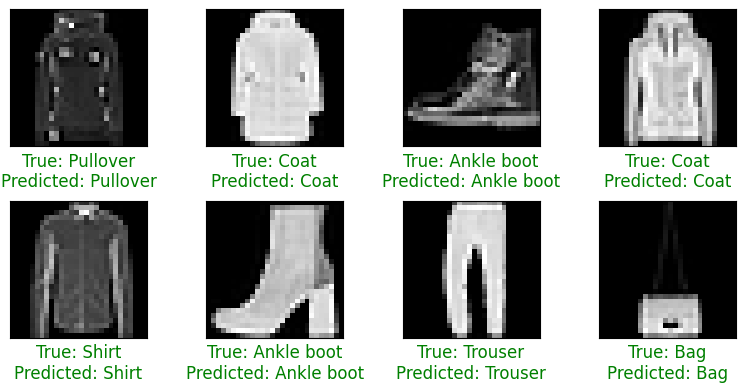

In [103]:
plot_data(X_test, y_test, y_proba)